In [1]:
#import required packages
#basics
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings

#stats
#from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
#import matplotlib_venn as venn

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords

#import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize

# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   


#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, decomposition, ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

#!pip install textblob
import  textblob
import xgboost
#from keras.preprocessing import text, sequence
#from keras import layers, models, optimizers

from textblob import TextBlob
from nltk.stem import PorterStemmer
import nltk
#nltk.download('stopwords')
#nltk.download('wordnet')
from textblob import Word 
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')


#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [3]:
# dataframe bank reviews
reviews=pd.read_excel('F:/KIRTI/python/5. Bank Reviews-Complaints Analysis/BankReviews.xlsx')

In [4]:
reviews.head()

,Date,Stars,Reviews,BankName
0,2017-04-10,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage
1,2017-02-10,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage
2,2017-08-21,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage
3,2017-12-17,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage
4,2016-05-27,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage


In [5]:
# Useful Columns
reviews=reviews[['Stars','Reviews','BankName']]
reviews.head()

,Stars,Reviews,BankName
0,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage
1,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage
2,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage
3,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage
4,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage


###  Data Exploratory

In [6]:
df=reviews

#### RegEX

In [7]:
df['Reviews'] = df['Reviews'].astype(str)
df['count_sent']=df['Reviews'].apply(lambda x: len(re.findall("\n",str(x)))+1)

#Word count in each comment:
df['count_word']=df['Reviews'].apply(lambda x: len(str(x).split()))

#Unique word count
df['count_unique_word']=df['Reviews'].apply(lambda x: len(set(str(x).split())))

#Letter count
df['count_letters']=df['Reviews'].apply(lambda x: len(str(x)))

#Word density

df['word_density'] = df['count_letters'] / (df['count_word']+1)

#punctuation count
df["count_punctuations"] =df['Reviews'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

#upper case words count
df["count_words_upper"] = df['Reviews'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

#upper case words count
df["count_words_lower"] = df['Reviews'].apply(lambda x: len([w for w in str(x).split() if w.islower()]))

#title case words count
df["count_words_title"] = df['Reviews'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

#Number of stopwords
df["count_stopwords"] = df['Reviews'].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

#Average length of the words
df["mean_word_len"] = df['Reviews'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

#Number of numeric
df['numeric'] = df['Reviews'].apply(lambda x :len([x for x in x.split() if x.isdigit()]))

#Number of alphanumeric
df['alphanumeric'] = df['Reviews'].apply(lambda x :len([x for x in x.split() if x.isalnum()]))

#Number of alphabetics
df['alphabetetics'] = df['Reviews'].apply(lambda x :len([x for x in x.split() if x.isalpha()]))

#Number of alphabetics
df['Spaces'] = df['Reviews'].apply(lambda x :len([x for x in x.split() if x.isspace()]))

#Number of Words ends with
df['words_ends_with_et'] = df['Reviews'].apply(lambda x :len([x for x in x.lower().split() if x.endswith('et')]))

#Number of Words ends with
df['words_start_with_no'] = df['Reviews'].apply(lambda x :len([x for x in x.lower().split() if x.startswith('no')]))

# Count the occurences of all words
df['wordcounts'] = df['Reviews'].apply(lambda x :dict([ [t, x.split().count(t)] for t in set(x.split()) ]))

pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

# function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

df['noun_count'] = df['Reviews'].apply(lambda x: check_pos_tag(x, 'noun'))
df['verb_count'] = df['Reviews'].apply(lambda x: check_pos_tag(x, 'verb'))
df['adj_count']  = df['Reviews'].apply(lambda x: check_pos_tag(x, 'adj'))
df['adv_count']  = df['Reviews'].apply(lambda x: check_pos_tag(x, 'adv'))
df['pron_count'] = df['Reviews'].apply(lambda x: check_pos_tag(x, 'pron')) 


### Calculating Sentiment analysis using Textblob module

In [8]:
df['sentiment'] = df["Reviews"].apply(lambda x: TextBlob(x).sentiment.polarity )

In [9]:
# Classification of stars on basis of reviews
reviews.Stars.value_counts()

5    410
1     95
Name: Stars, dtype: int64

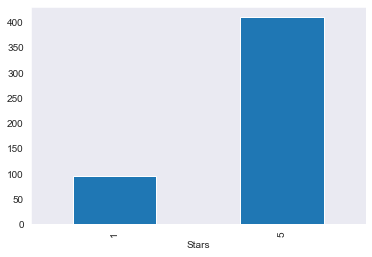

In [10]:
# Graphical Representation
reviews.groupby('Stars')['Reviews'].count().plot('bar')
plt.show()

In [11]:
len(df["Reviews"])

505

In [12]:
# Positive Reviews Percentage
previews=(df['sentiment']>0).sum()
(previews/len(df["Reviews"]))*100

92.27722772277228

In [13]:
# Neagtive Reviews Percentage
nreviews=(df['sentiment']<0).sum()
(nreviews/len(df["Reviews"]))*100

6.9306930693069315

In [14]:
# Neutral Reviews Percentage
neutral_reviews=(df['sentiment']==0).sum()
(neutral_reviews/len(df["Reviews"]))*100

0.7920792079207921

In [15]:
# Concatenation of all percentages
review_percent=pd.DataFrame(pd.concat([pd.Series(previews),pd.Series(nreviews),pd.Series(neutral_reviews)],axis=0))
review_percent.set_index(pd.Series(['previews', 'nreviews', 'neutral_reviews']), inplace=True)
review_percent

,0
previews,466
nreviews,35
neutral_reviews,4


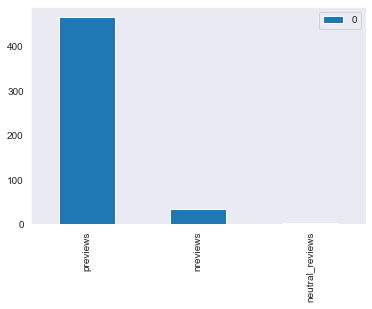

In [16]:
# Graphical Representation
review_percent.plot(kind='bar')
plt.show()

### Split the data into train & Test

In [17]:
# create a new DataFrame that only contains the 5-star and 1-star reviews
reviews_best_worst = reviews[(reviews.Stars==5) | (reviews.Stars==1)]

# define X and y
X = reviews.Reviews
y = reviews.Stars

# split the new DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(378,)
(127,)
(378,)
(127,)


In [18]:
reviews_best_worst

,Stars,Reviews,BankName,count_sent,count_word,count_unique_word,count_letters,word_density,count_punctuations,count_words_upper,...,Spaces,words_ends_with_et,words_start_with_no,wordcounts,noun_count,verb_count,adj_count,adv_count,pron_count,sentiment
0,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage,1,19,19,126,6.300000,4,0,...,0,0,0,"{'Thank': 1, 'Great': 1, 'Capital!': 1, 'throu...",8,3,1,1,3,0.533333
1,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage,1,25,23,159,6.115385,4,0,...,0,0,0,"{'correct': 1, 'is': 1, 'Thank': 1, 'you': 1, ...",7,3,4,2,4,0.453333
2,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage,1,79,64,462,5.775000,8,0,...,0,0,1,"{'without': 1, 'use': 1, 'together': 1, 'went'...",24,10,5,8,8,-0.033231
3,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage,1,108,78,605,5.550459,9,0,...,0,0,1,"{'ultimately': 1, 'a': 4, 'was': 1, 'us,': 1, ...",30,17,8,7,11,0.093740
4,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage,1,59,47,341,5.683333,6,3,...,0,0,1,"{'this': 1, 'during': 1, 'is': 1, 'me': 2, 'ca...",16,9,4,4,8,0.125000
5,5,I had the pleasure of working with Wyndham Cap...,Wyndham Capital Mortgage,1,79,56,459,5.737500,6,5,...,0,0,0,"{'selling)': 1, 'way': 1, 'a': 2, 'officer': 1...",22,11,7,6,5,0.345833
6,5,My experience with Mattison was beyond greatly...,Wyndham Capital Mortgage,1,52,40,305,5.754717,7,0,...,0,0,0,"{'she': 2, 'everything': 1, 'My': 1, 'is': 1, ...",9,9,2,6,11,0.313281
7,5,Patrick answered all my questions by email imm...,Wyndham Capital Mortgage,1,57,47,316,5.448276,6,1,...,0,0,0,"{'Very': 1, 'sure': 1, 'use': 1, 'making': 1, ...",13,10,4,6,7,0.238435
8,5,I loved working with this group of people! The...,Wyndham Capital Mortgage,1,72,61,414,5.671233,11,2,...,0,1,1,"{'this': 1, 'moved': 1, 'around': 1, 'say': 1,...",16,13,3,6,11,0.362500
9,5,Great web interface for both the loan applicat...,Wyndham Capital Mortgage,1,36,33,244,6.594595,7,0,...,0,0,0,"{'communicate': 1, 'Great': 1, 'weren't': 1, '...",16,2,2,4,1,0.566667


In [19]:
reviews.shape

(505, 27)

In [20]:
reviews.head(10)
#reviews.to_csv('re.csv')

,Stars,Reviews,BankName,count_sent,count_word,count_unique_word,count_letters,word_density,count_punctuations,count_words_upper,...,Spaces,words_ends_with_et,words_start_with_no,wordcounts,noun_count,verb_count,adj_count,adv_count,pron_count,sentiment
0,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage,1,19,19,126,6.300000,4,0,...,0,0,0,"{'Thank': 1, 'Great': 1, 'Capital!': 1, 'throu...",8,3,1,1,3,0.533333
1,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage,1,25,23,159,6.115385,4,0,...,0,0,0,"{'correct': 1, 'is': 1, 'Thank': 1, 'you': 1, ...",7,3,4,2,4,0.453333
2,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage,1,79,64,462,5.775000,8,0,...,0,0,1,"{'without': 1, 'use': 1, 'together': 1, 'went'...",24,10,5,8,8,-0.033231
3,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage,1,108,78,605,5.550459,9,0,...,0,0,1,"{'ultimately': 1, 'a': 4, 'was': 1, 'us,': 1, ...",30,17,8,7,11,0.093740
4,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage,1,59,47,341,5.683333,6,3,...,0,0,1,"{'this': 1, 'during': 1, 'is': 1, 'me': 2, 'ca...",16,9,4,4,8,0.125000
5,5,I had the pleasure of working with Wyndham Cap...,Wyndham Capital Mortgage,1,79,56,459,5.737500,6,5,...,0,0,0,"{'selling)': 1, 'way': 1, 'a': 2, 'officer': 1...",22,11,7,6,5,0.345833
6,5,My experience with Mattison was beyond greatly...,Wyndham Capital Mortgage,1,52,40,305,5.754717,7,0,...,0,0,0,"{'she': 2, 'everything': 1, 'My': 1, 'is': 1, ...",9,9,2,6,11,0.313281
7,5,Patrick answered all my questions by email imm...,Wyndham Capital Mortgage,1,57,47,316,5.448276,6,1,...,0,0,0,"{'Very': 1, 'sure': 1, 'use': 1, 'making': 1, ...",13,10,4,6,7,0.238435
8,5,I loved working with this group of people! The...,Wyndham Capital Mortgage,1,72,61,414,5.671233,11,2,...,0,1,1,"{'this': 1, 'moved': 1, 'around': 1, 'say': 1,...",16,13,3,6,11,0.362500
9,5,Great web interface for both the loan applicat...,Wyndham Capital Mortgage,1,36,33,244,6.594595,7,0,...,0,0,0,"{'communicate': 1, 'Great': 1, 'weren't': 1, '...",16,2,2,4,1,0.566667


### Creating user defined functions for clean the text and pre-process the data

In [21]:
#Abbrevations and Words correction
def clean_text(text):
    text = text.lower()
    text = text.strip()
    text = re.sub(r' +', ' ', text)
    text = re.sub(r"[-()\"#/@;:{}`+=~|.!?,'0-9]", "", text)
    return(text)

In [22]:
stop = set(nltk.corpus.stopwords.words('english'))

In [23]:
import string
def pre_process(text):
    #text = text.str.replace('/','')                           #Replacing the / with none
    #text = text.apply(lambda x: re.sub("  "," ", x))          #Replacing double space with single space
    #text = re.sub(r"[-()\"#/@;:{}`+=~|.!?,']", "", text)      #Replacing special character with none
    #text = re.sub(r'[0-9]+', '', text)                        #Replacing numbers with none
    #text = text.apply(lambda x: " ".join(x.translate(str.maketrans('', '', string.punctuation)) for x in x.split() if x.isalpha()))
    text = text.apply(lambda x: " ".join(x for x in x.split() if x not in stop)) #Removing stop words
    #text = text.apply(lambda x: str(TextBlob(x).correct()))                      #Correct spelling corrections
    #text = text.apply(lambda x: " ".join(PorterStemmer().stem(word) for word in x.split())) #Stemming using porter stemmer
    #text = text.apply(lambda x: " ".join(stemmer_func(word) for word in x.split()))        #Stemming
    #text = text.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))   #lemmatization
    #text = text.apply(lambda x: " ".join(word for word, pos in pos_tag(x.split()) if pos not in ['NN','NNS','NNP','NNPS'])) #Removing nouns etc
    return(text)

In [24]:
X_train = X_train.apply(lambda x: clean_text(x))
X_test = X_test.apply(lambda x: clean_text(x))

In [25]:
X_train=pre_process(X_train)
X_test=pre_process(X_test)

### Vectorization (count, tfidf) for both train & test

In [26]:
#Train
count_vect = CountVectorizer(analyzer='word', 
                             token_pattern=r'\w{1,}', 
                             ngram_range=(1, 3 ),  
                             encoding='latin-1' , 
                             max_df=0.9,min_df=0.001)
xtrain_count = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(xtrain_count)

#Test
#count_vect = CountVectorizer()
xtest_count = count_vect.transform(X_test)

#tfidf_transformer = TfidfTransformer()
X_test_tfidf = tfidf_transformer.transform(xtest_count)

In [27]:
xtrain_count

<378x21687 sparse matrix of type '<class 'numpy.int64'>'
	with 39602 stored elements in Compressed Sparse Row format>

### View the document term metrics

In [28]:
dtm2=pd.DataFrame(X_train_tfidf.toarray(), columns=count_vect.get_feature_names())

In [29]:
dtm2.head(10)

,aaron,aaron anyone,aaron anyone looking,aaron everything,aaron everything humanly,aaron extremely,aaron extremely help,aaron fought,aaron fought get,aaron looking,...,youi frustrated,youi frustrated himhe,zelada,zelada worked,zelada worked despite,zero,zero options,zero options said,zero point,zero point rate
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.070704,0.070704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern='\w{1,}', ngram_range=(1, 3), max_df=0.9,min_df=0.001)
tfidf_vect_ngram.fit(df['Reviews'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)
xtest_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)

In [31]:
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern='\w{1,}', ngram_range=(1,3), max_df=0.9,min_df=0.001)
tfidf_vect_ngram_chars.fit(df['Reviews'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(X_train) 
xtest_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(X_test)

### Topic Modeling

In [32]:
# train a LDA Model
lda_model = decomposition.LatentDirichletAllocation(n_components=20, learning_method='batch', max_iter=50)
X_topics = lda_model.fit_transform(X_train_tfidf)
topic_word = lda_model.components_ 
vocab = count_vect.get_feature_names()

In [42]:
# view the topic models
n_top_words = 10
topic_summaries = []
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))

topic_summaries

['wyndham buyers first time home time home home buyers time home buyers competitive brad help great first time',
 'helpful great customer helpful great work responsive inquiries responsive inquiries great work responsive great customer great customer service inquiries work responsive mr germain',
 'john matthew saying round select th etc emails fees always',
 'always steve much things couldnt sure say got going stressful',
 'outstanding service outstanding service always always timely service always timely outstanding service always timely always service lender got',
 'throughout process great work kept staff friendly staff friendly great informed throughout process friendly great work well informed throughout informed throughout friendly great work kept',
 'informative responsive informative responsive helped us every know helped us still able get issues end didnt end didnt know know still',
 'mortgage loan made mortgage asset husband patient accurate extremely simple extremely simple

##### Topics:
           1. Mortgage Loan
           2. communication friendly
           3. informative response
           4. Hardworking staff
           5. Customer oriented professional
           6. Work On Time

### Bank data - Word clouds

In [57]:
frequency_words_wo_stop= {}
for data in reviews['Reviews']:
    tokens = nltk.wordpunct_tokenize(data.lower())
    for token in tokens:
        if token.lower() not in stop:
            if token in frequency_words_wo_stop:
                count = frequency_words_wo_stop[token]
                count = count + 1
                frequency_words_wo_stop[token] = count
            else:
                frequency_words_wo_stop[token] = 1

In [58]:
frequency_words_wo_stop

{'great': 139,
 'job': 25,
 ',': 1135,
 'wyndham': 16,
 'capital': 12,
 '!': 222,
 'person': 17,
 'professional': 70,
 'helped': 35,
 'us': 207,
 'move': 12,
 'refinance': 70,
 'process': 253,
 'smoothly': 15,
 '.': 1976,
 'thank': 50,
 'matthew': 3,
 'richardson': 1,
 'helpful': 56,
 'find': 19,
 'correct': 1,
 'product': 10,
 'mortgage': 147,
 'much': 38,
 'excellent': 30,
 'service': 99,
 'past': 13,
 'experience': 110,
 'would': 246,
 'without': 29,
 'question': 7,
 'use': 48,
 'needed': 29,
 '!!': 24,
 'went': 70,
 'beyond': 25,
 'extra': 19,
 'mile': 8,
 'right': 28,
 'wrong': 7,
 'encountered': 7,
 'servicer': 3,
 'dealing': 14,
 'previous': 13,
 'loan': 313,
 'pulled': 4,
 'together': 8,
 'found': 16,
 'viable': 3,
 'option': 8,
 'ultimately': 5,
 'saved': 7,
 'money': 22,
 'highly': 65,
 'recommend': 156,
 'brad': 7,
 'thomka': 3,
 'team': 113,
 'needs': 27,
 'sincerest': 2,
 'thanks': 61,
 'ed': 2,
 '&': 30,
 'lind': 1,
 'beginning': 32,
 'started': 17,
 'stressful': 24,
 'ti

In [59]:
from wordcloud import WordCloud ,STOPWORDS

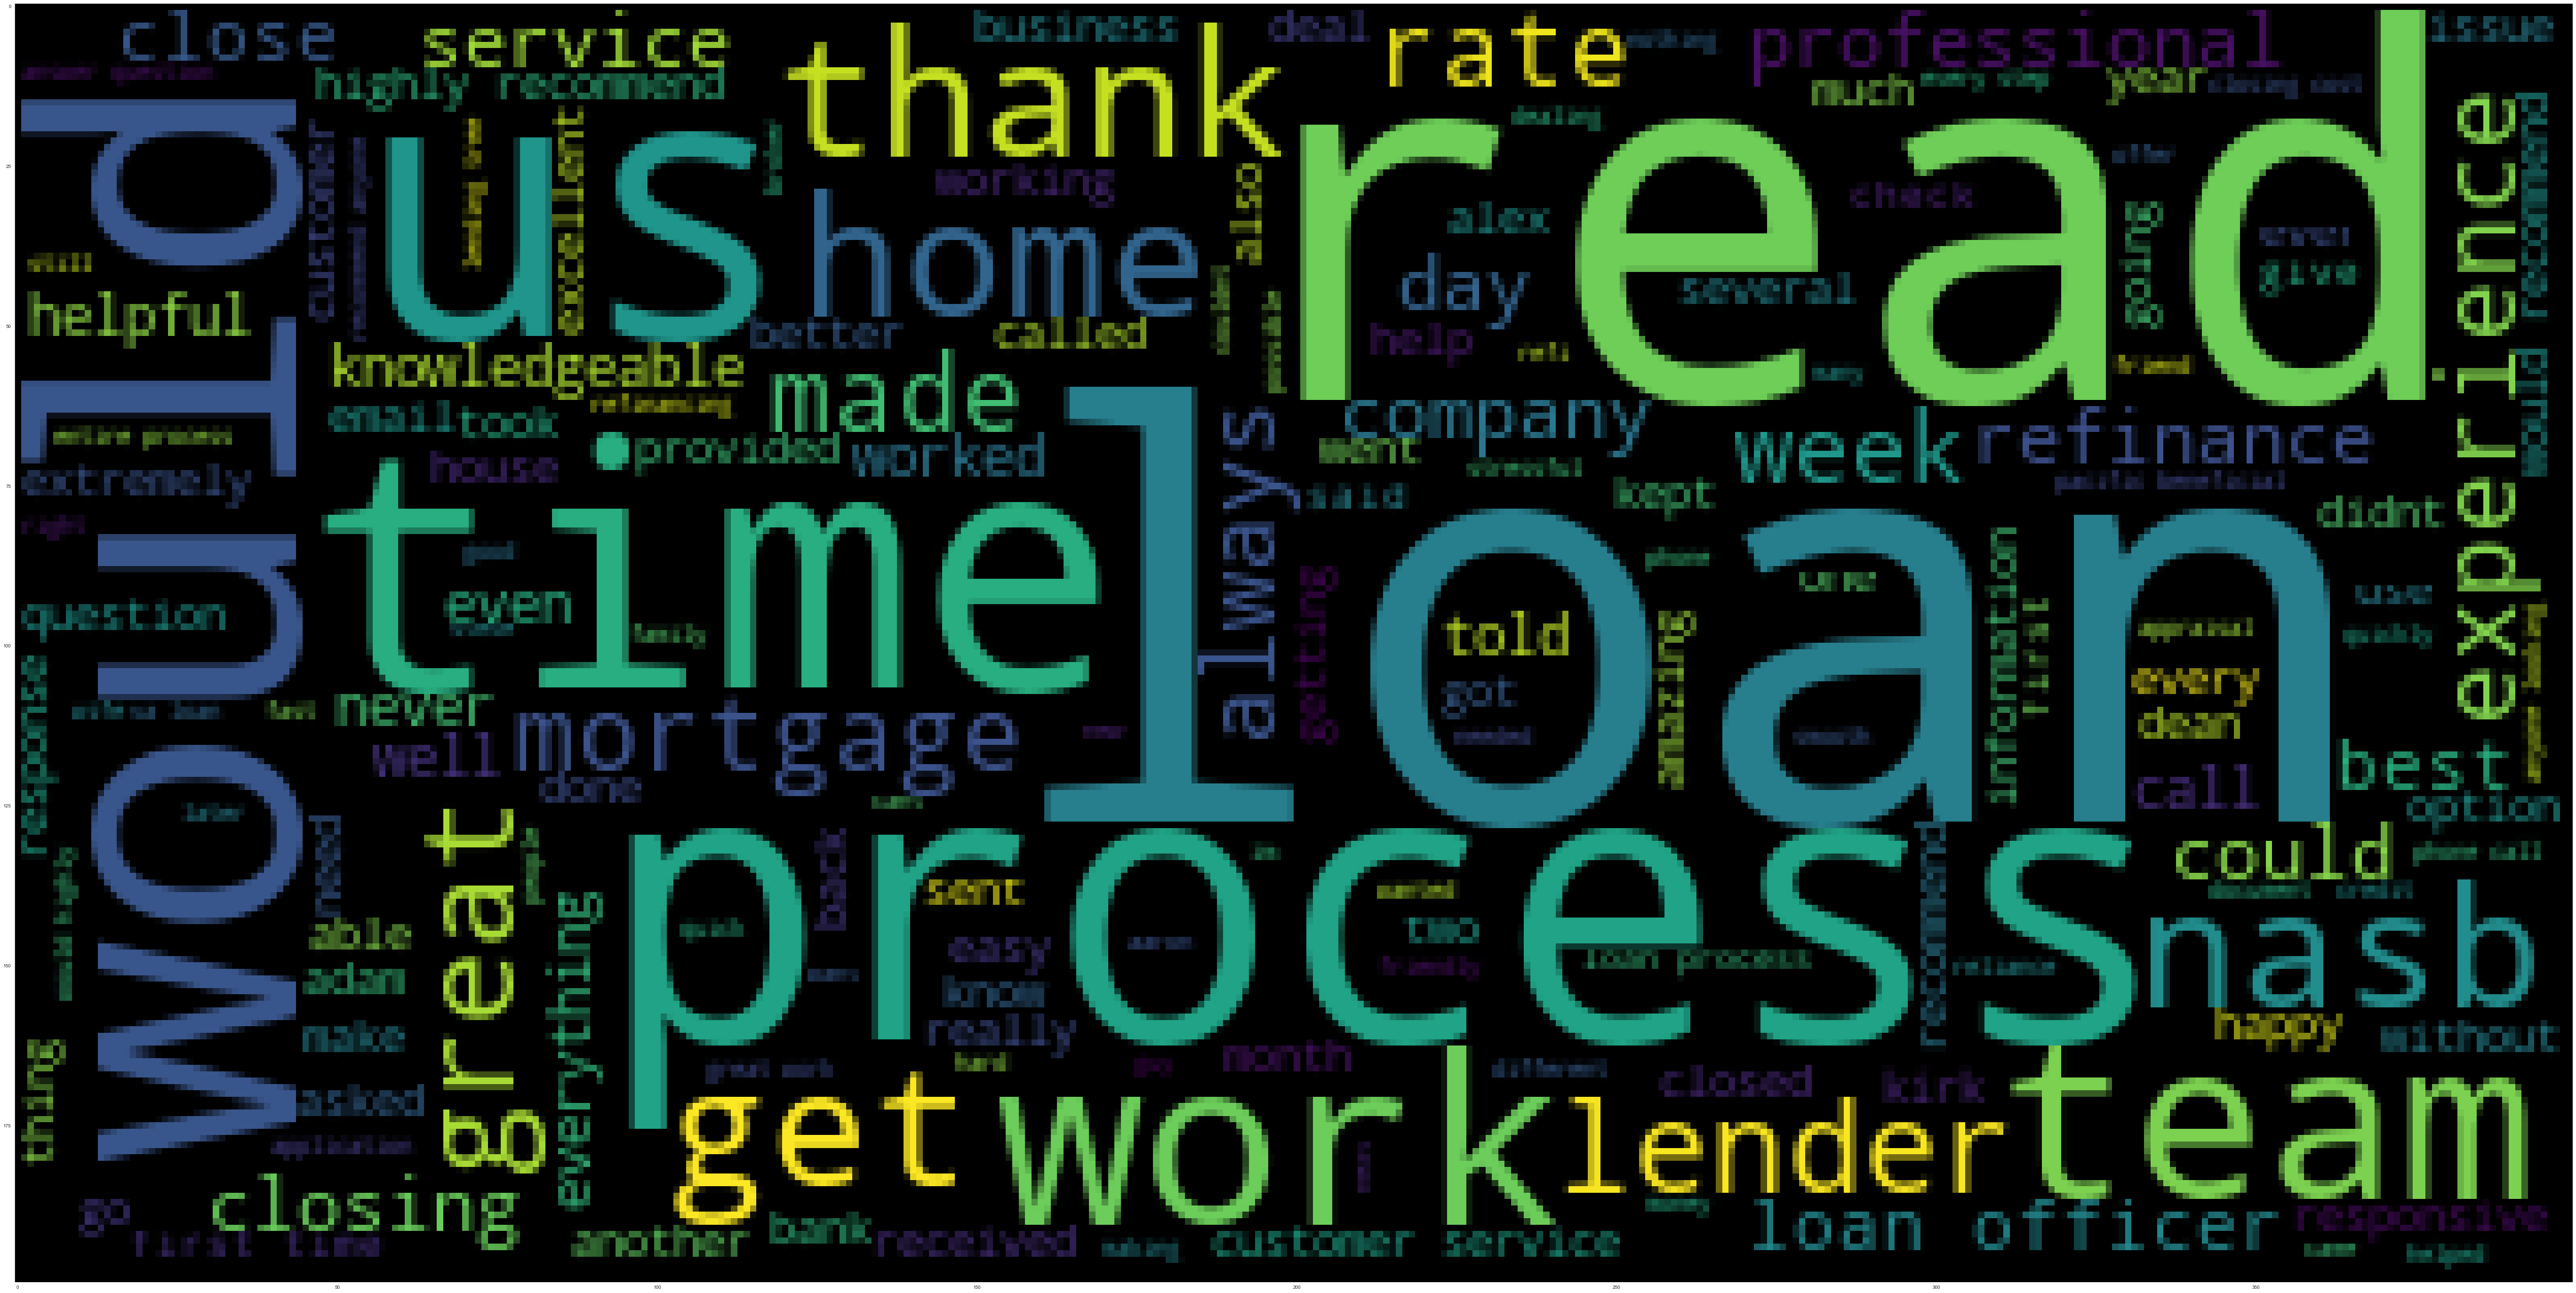

In [60]:
wordcloud = WordCloud(stopwords=[]).generate(' '.join(X_train.tolist()))

%matplotlib inline
fig = plt.figure(figsize=(200,50))
plt.imshow(wordcloud)

### Create user defined function for train the models

In [61]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid,  valid_y, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

### Building different models with different vectors

In [67]:
#Naive Bayes
# Naive Bayes on Count Vectors and TF-IDF
accuracy_L1 = train_model(naive_bayes.MultinomialNB(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("NB  for L1, Count Vectors: ", accuracy_L1)

NB  for L1, Count Vectors:  0.84251968503937


In [68]:
# Naive Bayes on Word Level TF IDF Vectors
accuracy_L1 = train_model(naive_bayes.MultinomialNB(), xtrain_count, y_train, xtest_count, y_test)
print("NB  for L1, WordLevel TF-IDF: ", accuracy_L1)

NB  for L1, WordLevel TF-IDF:  0.9448818897637795


In [69]:
# Naive Bayes on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, y_test)
print("NB  for L1, N-Gram Vectors: ", accuracy_L1)



# Naive Bayes on Character Level TF IDF Vectors
accuracy_L1 = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, y_train, xtest_tfidf_ngram_chars, y_test)
print("NB for L1, CharLevel Vectors: ", accuracy_L1)

NB  for L1, N-Gram Vectors:  0.8031496062992126
NB for L1, CharLevel Vectors:  0.8031496062992126


In [70]:
#Logistic Regression
# Logistic Regression on Count Vectors and TF-IDF
accuracy_L1 = train_model(LogisticRegression(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("LR  for L1, Count Vectors: ", accuracy_L1)



# Logistic Regression on Word Level TF IDF Vectors
accuracy_L1 = train_model(LogisticRegression(), xtrain_count, y_train, xtest_count, y_test)
print("LR  for L1, WordLevel TF-IDF: ", accuracy_L1)



# Logistic Regression on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(LogisticRegression(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, y_test)
print("LR  for L1, N-Gram Vectors: ", accuracy_L1)



# Logistic Regression on Character Level TF IDF Vectors
accuracy_L1 = train_model(LogisticRegression(), xtrain_tfidf_ngram_chars, y_train, xtest_tfidf_ngram_chars, y_test)
print("LR for L1, CharLevel Vectors: ", accuracy_L1)

LR  for L1, Count Vectors:  0.8188976377952756
LR  for L1, WordLevel TF-IDF:  0.9212598425196851
LR  for L1, N-Gram Vectors:  0.8188976377952756
LR for L1, CharLevel Vectors:  0.84251968503937


In [71]:
#Linear SVC
# Linear SVC on Count Vectors and TF-IDF
accuracy_L1 = train_model(svm.LinearSVC(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("SVC  for L1, Count Vectors: ", accuracy_L1)



# Linear SVC on Word Level TF IDF Vectors
accuracy_L1 = train_model(svm.LinearSVC(), xtrain_count, y_train, xtest_count, y_test)
print("SVC  for L1, WordLevel TF-IDF: ", accuracy_L1)



# Linear SVC on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(svm.LinearSVC(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, y_test)
print("SVC  for L1, N-Gram Vectors: ", accuracy_L1)



# Linear SVC on Character Level TF IDF Vectors
accuracy_L1 = train_model(svm.LinearSVC(), xtrain_tfidf_ngram_chars, y_train, xtest_tfidf_ngram_chars, y_test)
print("SVC for L1, CharLevel Vectors: ", accuracy_L1)

SVC  for L1, Count Vectors:  0.937007874015748
SVC  for L1, WordLevel TF-IDF:  0.937007874015748
SVC  for L1, N-Gram Vectors:  0.9291338582677166
SVC for L1, CharLevel Vectors:  0.9448818897637795


In [72]:
#Random Forest
# Random Forest on Count Vectors and TF-IDF
accuracy_L1 = train_model(RandomForestClassifier(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("LR  for L1, Count Vectors: ", accuracy_L1)



# Random Forest on Word Level TF IDF Vectors
accuracy_L1 = train_model(RandomForestClassifier(), xtrain_count, y_train, xtest_count, y_test)
print("LR  for L1, WordLevel TF-IDF: ", accuracy_L1)



# Random Forest on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(RandomForestClassifier(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, y_test)
print("LR  for L1, N-Gram Vectors: ", accuracy_L1)



# Random Forest on Character Level TF IDF Vectors
accuracy_L1 = train_model(RandomForestClassifier(), xtrain_tfidf_ngram_chars, y_train, xtest_tfidf_ngram_chars, y_test)
print("LR for L1, CharLevel Vectors: ", accuracy_L1)

LR  for L1, Count Vectors:  0.905511811023622
LR  for L1, WordLevel TF-IDF:  0.889763779527559
LR  for L1, N-Gram Vectors:  0.8740157480314961
LR for L1, CharLevel Vectors:  0.9133858267716536


In [73]:
#XGBoosting
# XGBoosting on Count Vectors and TF-IDF
accuracy_L1 = train_model(XGBClassifier(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("LR  for L1, Count Vectors: ", accuracy_L1)



# XGBoosting on Word Level TF IDF Vectors
accuracy_L1 = train_model(XGBClassifier(), xtrain_count, y_train, xtest_count, y_test)
print("LR  for L1, WordLevel TF-IDF: ", accuracy_L1)



# XGBoosting on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(XGBClassifier(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, y_test)
print("LR  for L1, N-Gram Vectors: ", accuracy_L1)



# XGBoosting on Character Level TF IDF Vectors
accuracy_L1 = train_model(XGBClassifier(), xtrain_tfidf_ngram_chars, y_train, xtest_tfidf_ngram_chars, y_test)
print("LR for L1, CharLevel Vectors: ", accuracy_L1)

LR  for L1, Count Vectors:  0.9448818897637795
LR  for L1, WordLevel TF-IDF:  0.9212598425196851
LR  for L1, N-Gram Vectors:  0.937007874015748
LR for L1, CharLevel Vectors:  0.9212598425196851


In [74]:
#Gradient Boosting
# Gradient Boosting on Count Vectors and TF-IDF
accuracy_L1 = train_model(GradientBoostingClassifier(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("LR  for L1, Count Vectors: ", accuracy_L1)



# Gradient Boosting on Word Level TF IDF Vectors
accuracy_L1 = train_model(GradientBoostingClassifier(), xtrain_count, y_train, xtest_count, y_test)
print("LR  for L1, WordLevel TF-IDF: ", accuracy_L1)



# Gradient Boosting on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(GradientBoostingClassifier(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, y_test)
print("LR  for L1, N-Gram Vectors: ", accuracy_L1)



# Gradient Boosting on Character Level TF IDF Vectors
accuracy_L1 = train_model(GradientBoostingClassifier(), xtrain_tfidf_ngram_chars, y_train, xtest_tfidf_ngram_chars, y_test)
print("LR for L1, CharLevel Vectors: ", accuracy_L1)

LR  for L1, Count Vectors:  0.937007874015748
LR  for L1, WordLevel TF-IDF:  0.937007874015748
LR  for L1, N-Gram Vectors:  0.9212598425196851
LR for L1, CharLevel Vectors:  0.905511811023622


In [75]:
#ANN
# ANN on Count Vectors and TF-IDF
accuracy_L1 = train_model(MLPClassifier(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("LR  for L1, Count Vectors: ", accuracy_L1)



# ANN on Word Level TF IDF Vectors
accuracy_L1 = train_model(MLPClassifier(), xtrain_count, y_train, xtest_count, y_test)
print("LR  for L1, WordLevel TF-IDF: ", accuracy_L1)



# ANN on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(MLPClassifier(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, y_test)
print("LR  for L1, N-Gram Vectors: ", accuracy_L1)



# ANN on Character Level TF IDF Vectors
accuracy_L1 = train_model(MLPClassifier(), xtrain_tfidf_ngram_chars, y_train, xtest_tfidf_ngram_chars, y_test)
print("LR for L1, CharLevel Vectors: ", accuracy_L1)

LR  for L1, Count Vectors:  0.905511811023622
LR  for L1, WordLevel TF-IDF:  0.8740157480314961
LR  for L1, N-Gram Vectors:  0.968503937007874
LR for L1, CharLevel Vectors:  0.968503937007874


In [76]:
#ANN + logistic
# ANN + logistic on Count Vectors and TF-IDF
accuracy_L1 = train_model(MLPClassifier(activation='logistic'), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("LR  for L1, Count Vectors: ", accuracy_L1)



# ANN + logistic on Word Level TF IDF Vectors
accuracy_L1 = train_model(MLPClassifier(activation='logistic'), xtrain_count, y_train, xtest_count, y_test)
print("LR  for L1, WordLevel TF-IDF: ", accuracy_L1)



# ANN + logistic on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(MLPClassifier(activation='logistic'), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, y_test)
print("LR  for L1, N-Gram Vectors: ", accuracy_L1)



# ANN + logistic on Character Level TF IDF Vectors
accuracy_L1 = train_model(MLPClassifier(activation='logistic'), xtrain_tfidf_ngram_chars, y_train, xtest_tfidf_ngram_chars, y_test)
print("LR for L1, CharLevel Vectors: ", accuracy_L1)

LR  for L1, Count Vectors:  0.8818897637795275
LR  for L1, WordLevel TF-IDF:  0.8818897637795275
LR  for L1, N-Gram Vectors:  0.8976377952755905
LR for L1, CharLevel Vectors:  0.9291338582677166


In [77]:
#OneVsRest + XGBoosting
# OneVsRest + XGBoosting on Count Vectors and TF-IDF
accuracy_L1 = train_model(OneVsRestClassifier(XGBClassifier()), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("LR  for L1, Count Vectors: ", accuracy_L1)



# OneVsRest + XGBoosting on Word Level TF IDF Vectors
accuracy_L1 = train_model(OneVsRestClassifier(XGBClassifier()), xtrain_count, y_train, xtest_count, y_test)
print("LR  for L1, WordLevel TF-IDF: ", accuracy_L1)



# OneVsRest + XGBoosting on Ngram Level TF IDF Vectors
accuracy_L1 = train_model(OneVsRestClassifier(XGBClassifier()), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, y_test)
print("LR  for L1, N-Gram Vectors: ", accuracy_L1)



# OneVsRest + XGBoosting on Character Level TF IDF Vectors
accuracy_L1 = train_model(OneVsRestClassifier(XGBClassifier()), xtrain_tfidf_ngram_chars, y_train, xtest_tfidf_ngram_chars, y_test)
print("LR for L1, CharLevel Vectors: ", accuracy_L1)

LR  for L1, Count Vectors:  0.9448818897637795
LR  for L1, WordLevel TF-IDF:  0.9212598425196851
LR  for L1, N-Gram Vectors:  0.937007874015748
LR for L1, CharLevel Vectors:  0.9212598425196851


### Adding Features to a Document-Term Matrix

In [78]:
# create a DataFrame that only contains the 5-star and 1-star reviews
reviews = reviews[(reviews.Stars==5) | (reviews.Stars==1)]

# define X and y
feature_cols = ['Reviews','sentiment']
X = reviews[feature_cols]
y = reviews.Stars

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1)

In [79]:
# use CountVectorizer with text column only
vect = TfidfVectorizer(lowercase=True, stop_words='english', max_df=0.9,min_df=0.001, ngram_range=(2,3))
X_train_dtm = vect.fit_transform(X_train.Reviews)
X_test_dtm = vect.transform(X_test.Reviews)
print(X_train_dtm.shape)
print(X_test_dtm.shape)

# shape of other four feature columns
X_train.drop('Reviews', axis=1).shape

(378, 16904)
(127, 16904)


(378, 1)

In [80]:
# use CountVectorizer with text column only
vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train.Reviews)
X_test_dtm = vect.transform(X_test.Reviews)
print(X_train_dtm.shape)
print(X_test_dtm.shape)

# shape of other four feature columns
X_train.drop('Reviews', axis=1).shape

(378, 2438)
(127, 2438)


(378, 1)

In [81]:
# cast other feature columns to float and convert to a sparse matrix
extra = sparse.csr_matrix(X_train.drop('Reviews', axis=1).astype(float))
extra.shape

# combine sparse matrices
X_train_dtm_extra = sparse.hstack((X_train_dtm, extra))
X_train_dtm_extra.shape

# repeat for testing set
extra = sparse.csr_matrix(X_test.drop('Reviews', axis=1).astype(float))
X_test_dtm_extra = sparse.hstack((X_test_dtm, extra))
X_test_dtm_extra.shape

(127, 2439)

In [82]:
# use logistic regression with text column only
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train_dtm, y_train)
y_pred_class = logreg.predict(X_test_dtm)
acc_log=metrics.accuracy_score(y_test, y_pred_class)
acc_log

0.968503937007874

In [83]:
# use logistic regression with all features
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train_dtm_extra, y_train)
y_pred_class = logreg.predict(X_test_dtm_extra)
acc_log1=metrics.accuracy_score(y_test, y_pred_class)
acc_log1

0.952755905511811

In [84]:
# use random forest with text column only
rmf = RandomForestClassifier()
rmf.fit(X_train_dtm, y_train)
y_pred_class = rmf.predict(X_test_dtm)
acc_rmf=metrics.accuracy_score(y_test, y_pred_class)
acc_rmf

0.9133858267716536

In [85]:
# use random forest with all features
rmf = RandomForestClassifier()
rmf.fit(X_train_dtm_extra, y_train)
y_pred_class = rmf.predict(X_test_dtm_extra)
acc_rmf1=metrics.accuracy_score(y_test, y_pred_class)
acc_rmf1

0.937007874015748

In [86]:
# use gradient boosting with text column only
gbc =  GradientBoostingClassifier()
gbc.fit(X_train_dtm, y_train)
y_pred_class = gbc.predict(X_test_dtm)
acc_grad=metrics.accuracy_score(y_test, y_pred_class)
acc_grad

0.9291338582677166

In [87]:
# use gradient boosting with all features
gbc = GradientBoostingClassifier()
gbc.fit(X_train_dtm_extra, y_train)
y_pred_class = gbc.predict(X_test_dtm_extra)
acc_grad1=metrics.accuracy_score(y_test, y_pred_class)
acc_grad1

0.9212598425196851

In [88]:
# use Xgboosting with text column only
xgb =  XGBClassifier()
xgb.fit(X_train_dtm, y_train)
y_pred_class = xgb.predict(X_test_dtm)
acc_xgb=metrics.accuracy_score(y_test, y_pred_class)
acc_xgb

0.9448818897637795

In [89]:
# use Xgboosting with all features
xgb = XGBClassifier()
xgb.fit(X_train_dtm_extra, y_train)
y_pred_class = xgb.predict(X_test_dtm_extra)
acc_xgb1=metrics.accuracy_score(y_test, y_pred_class)
acc_xgb1

0.937007874015748

In [97]:
# use ANN with text column only
mp = MLPClassifier()
mp.fit(X_train_dtm, y_train)
y_pred_class = mp.predict(X_test_dtm)
acc_mlp=metrics.accuracy_score(y_test, y_pred_class)
acc_mlp

0.9763779527559056

In [98]:
# use ANN with all features
mp = MLPClassifier()
mp.fit(X_train_dtm_extra, y_train)
y_pred_class = mp.predict(X_test_dtm_extra)
acc_mlp1=metrics.accuracy_score(y_test, y_pred_class)
acc_mlp1

0.9763779527559056

In [92]:
# use ANN+logistic with text column only
mp = MLPClassifier(activation='logistic')
mp.fit(X_train_dtm, y_train)
y_pred_class = mp.predict(X_test_dtm)
acc_mlp_ln=metrics.accuracy_score(y_test, y_pred_class)
acc_mlp_ln

0.9448818897637795

In [93]:
# use ANN+logistic with all features
mp = MLPClassifier(activation='logistic')
mp.fit(X_train_dtm_extra, y_train)
y_pred_class = mp.predict(X_test_dtm_extra)
acc_mlp_ln1=metrics.accuracy_score(y_test, y_pred_class)
acc_mlp_ln1

0.9448818897637795

In [94]:
# use OneVsRest + XGBoosting with text column only
one_xgb = OneVsRestClassifier(XGBClassifier())
one_xgb.fit(X_train_dtm, y_train)
y_pred_class = one_xgb.predict(X_test_dtm)
acc_one_xgb=metrics.accuracy_score(y_test, y_pred_class)
acc_one_xgb


0.9448818897637795

In [95]:
# use OneVsRest + XGBoosting with all features
one_xgb = OneVsRestClassifier(XGBClassifier())
one_xgb.fit(X_train_dtm_extra, y_train)
y_pred_class = one_xgb.predict(X_test_dtm_extra)
acc_one_xgb1=metrics.accuracy_score(y_test, y_pred_class)
acc_one_xgb1

0.937007874015748

Text(0.5, 16.0, 'Predicted label')

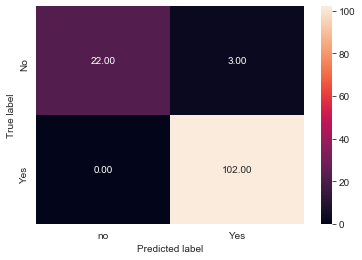

In [102]:
cm = metrics.confusion_matrix( y_test, y_pred_class)
sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = ["no", "Yes"] , yticklabels = ["No", "Yes"] )
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [100]:
models = pd.DataFrame({
    'Model': ['Logistic Regression','Random Forest', 'XGBoosting','Gradient Boosting','ANN','ANN + logistic','OneVsRest + XGBoosting'],
    
    'Score': [acc_log,acc_rmf,acc_grad,acc_xgb,acc_mlp,acc_mlp_ln,acc_one_xgb]
    })

models.sort_values(by='Score', ascending=False)

,Model,Score
4,ANN,0.976378
0,Logistic Regression,0.968504
3,Gradient Boosting,0.944882
5,ANN + logistic,0.944882
6,OneVsRest + XGBoosting,0.944882
2,XGBoosting,0.929134
1,Random Forest,0.913386


In [101]:
models = pd.DataFrame({
    'Model': ['Logistic Regression','Random Forest', 'XGBoosting','Gradient Boosting','ANN','ANN + logistic','OneVsRest + XGBoosting'],
    
    'Score': [acc_log1,acc_rmf1,acc_grad1,acc_xgb1,acc_mlp1,acc_mlp_ln1,acc_one_xgb1]
    })

models.sort_values(by='Score', ascending=False)

,Model,Score
4,ANN,0.976378
0,Logistic Regression,0.952756
5,ANN + logistic,0.944882
1,Random Forest,0.937008
3,Gradient Boosting,0.937008
6,OneVsRest + XGBoosting,0.937008
2,XGBoosting,0.921260


#### Customer satisfaction with the reviews is best predicted by neural networks model (ANN).

In [39]:
reviews.to_json?